In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df = pd.read_csv('Global Weather Repository.csv')
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.400,26.600,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.100,2.000,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.400,18.400,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.700,0.900,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.400,262.300,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1743584400,2025-04-02 05:00,25.0,77.0,Partly cloudy,...,10.545,11.840,1,1,06:24 AM,06:38 PM,09:55 AM,11:11 PM,Waxing Crescent,19
62359,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1743584400,2025-04-02 16:00,25.0,77.0,Sunny,...,236.060,245.495,5,10,05:49 AM,06:11 PM,08:32 AM,10:33 PM,Waxing Crescent,15
62360,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1743584400,2025-04-02 12:00,22.8,73.1,Sunny,...,22.200,208.865,2,2,05:58 AM,06:16 PM,09:01 AM,10:38 PM,Waxing Crescent,17
62361,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1743584400,2025-04-02 11:00,25.7,78.2,Patchy rain nearby,...,4.995,5.735,1,1,06:12 AM,06:08 PM,10:13 AM,09:36 PM,Waxing Crescent,17


In [3]:
columns = df.columns.to_list()
object_columms = ['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'condition_text', 'wind_direction', 'last_updated', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']
numeric_columns = list(set(df.columns) - set(object_columms))

##### Feature classification
The features can be initialy categorized as follows
- Numerical:
    - humidity
    - cloud
    - uv_index
    - air_quality
        - air_quality_gb-defra-index
        - air_quality_PM2.5
        - air_quality_Nitrogen_dioxide
        - air_quality_PM10
        - air_quality_Carbon_Monoxide
        - air_quality_Ozone
        - air_quality_Sulphur_dioxide
        - air_quality_us-epa-index
    - wind
        - wind_kph
        - wind_mph
        - wind_degree
        - gust_kph
        - gust_mph
    - pressure
        - pressure_mb
        - pressure_in
    - visibility
        - visibility_km
        - visibility_miles
    - precipitation
        - precip_mm
        - precip_in
    - temperature
        - temperature_celsius
        - feels_like_celsius
        - temperature_fahrenheit
        - feels_like_fahrenheit



- Categorial:
    - country
    - location name
    - latitude
    - longitude
    - timezone
    - wind_direction
    - last_direction
    - moon_phase
    - moon_illumination


- Time:
    - sunrise
    - sunset
    - moonrise
    - moonset


- Object/Text:
    - last_updated_epoch 
    - last_updated
    - condition_text

##### Data Cleaning & Preprocessing

In [4]:
# Finding missing values
missing_values = df.isnull().sum()
summary_stats = df.describe()
missing_values.sum() # there is no missing value

0

In [6]:
# Finding outliers
outlier_info = {}
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    outlier_info[col] = len(outliers)

# Normalize the selected columns using Min-Max scaling
normalized_df = df.copy()
for col in numeric_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    normalized_df[col + '_normalized'] = (df[col] - min_val) / (max_val - min_val)

##### EDA

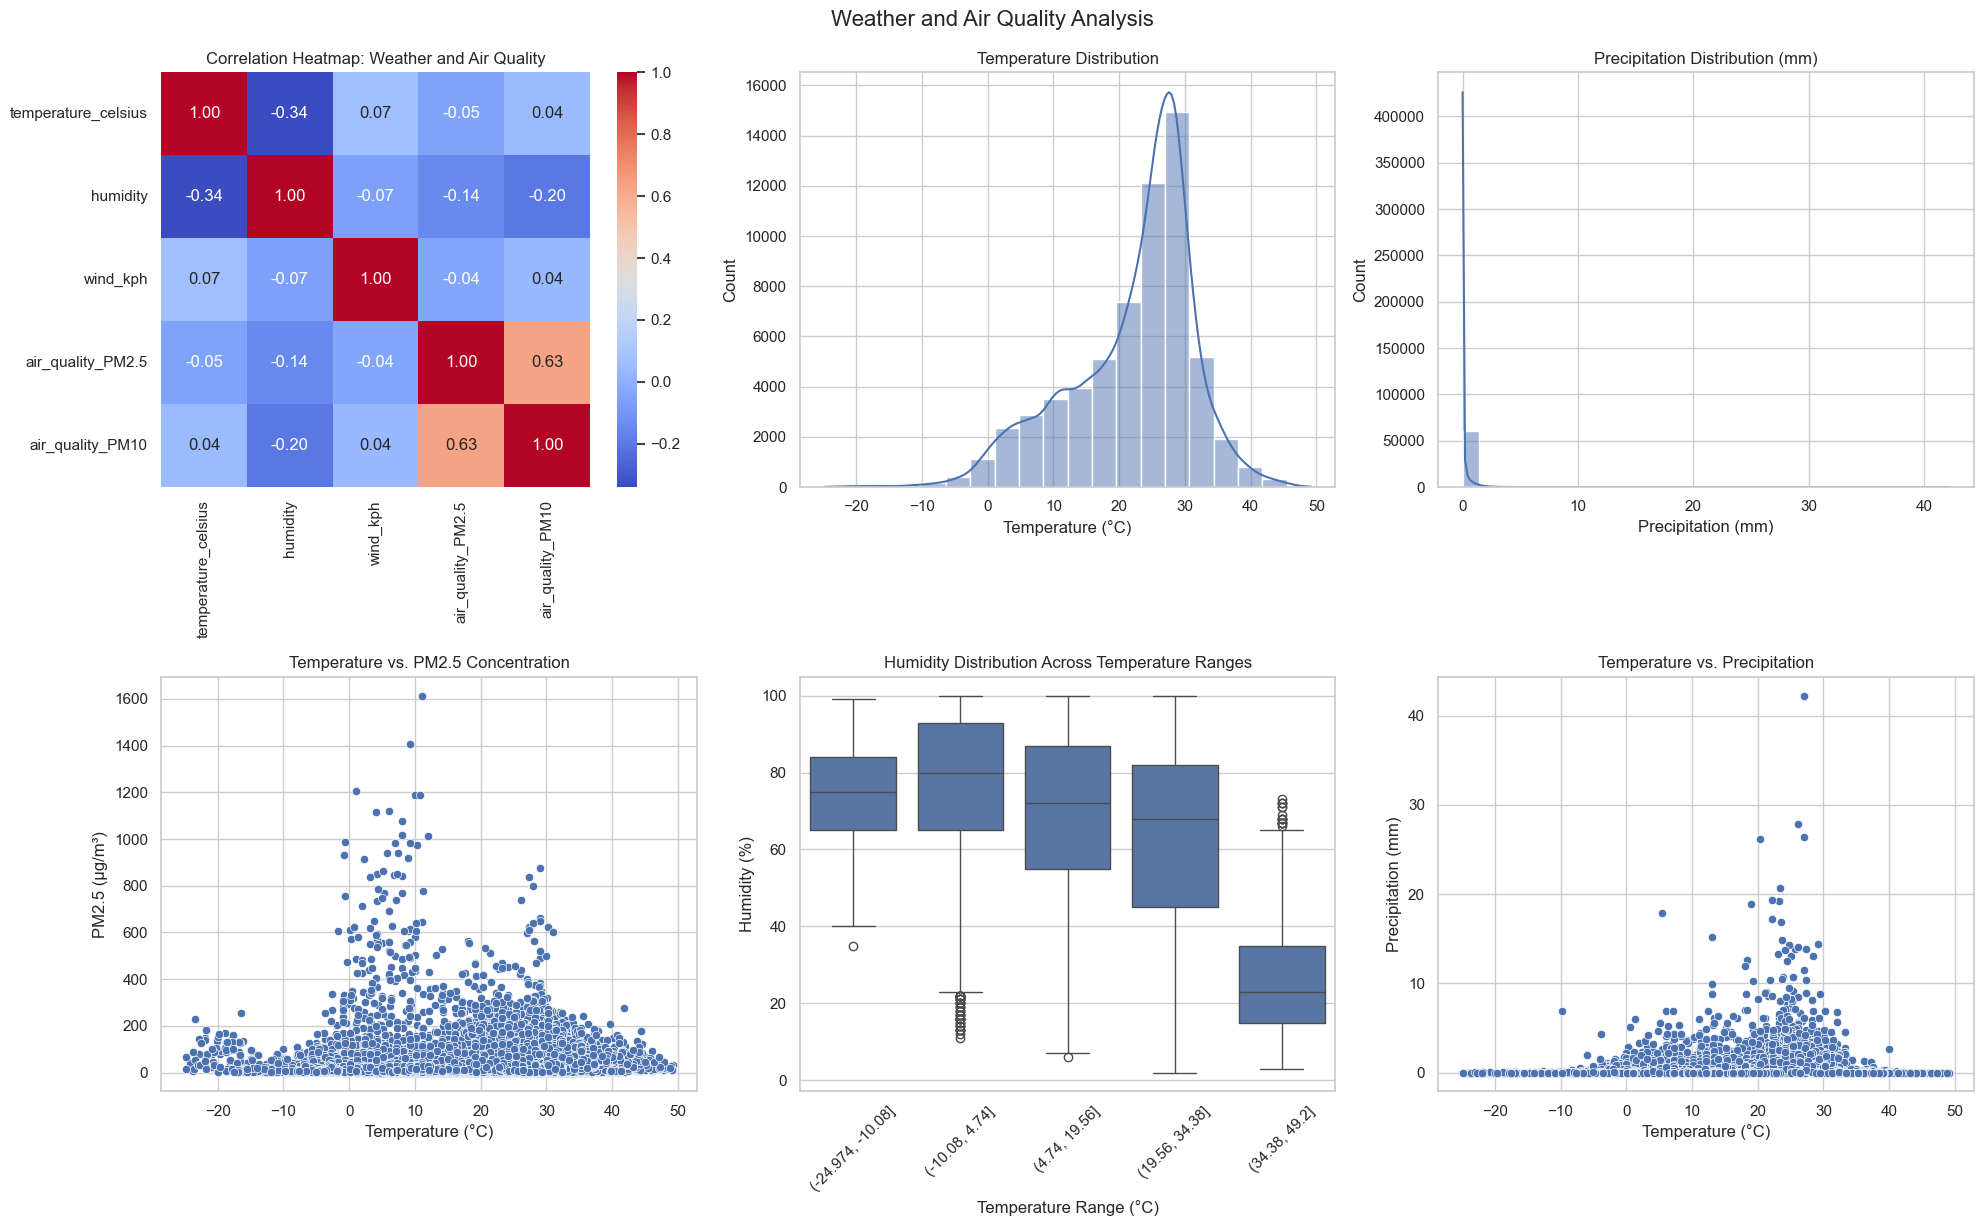

In [ ]:
sns.set(style="whitegrid")
df['last_updated'] = pd.to_datetime(df['last_updated'])

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Correlation heatmap
corr_matrix = df[[
    'temperature_celsius', 'humidity', 'wind_kph',
    'air_quality_PM2.5', 'air_quality_PM10'
]].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0, 0])
axes[0, 0].set_title("Correlation Heatmap: Weather and Air Quality")

# 2. Temperature distribution
sns.histplot(df['temperature_celsius'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Temperature Distribution")
axes[0, 1].set_xlabel("Temperature (°C)")

# 3. Scatter plot: Temperature vs. PM2.5
sns.scatterplot(x='temperature_celsius', y='air_quality_PM2.5', data=df, ax=axes[1, 0])
axes[1, 0].set_title("Temperature vs. PM2.5 Concentration")
axes[1, 0].set_xlabel("Temperature (°C)")
axes[1, 0].set_ylabel("PM2.5 (µg/m³)")

# 4. Box plot: Humidity across temperature ranges
df['temp_bin'] = pd.cut(df['temperature_celsius'], bins=5)
sns.boxplot(x='temp_bin', y='humidity', data=df, ax=axes[1, 1])
axes[1, 1].set_title("Humidity Distribution Across Temperature Ranges")
axes[1, 1].set_xlabel("Temperature Range (°C)")
axes[1, 1].set_ylabel("Humidity (%)")
axes[1, 1].tick_params(axis='x', rotation=45)

# 5. Precipitation distribution
sns.histplot(df['precip_mm'], bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title("Precipitation Distribution (mm)")
axes[0, 2].set_xlabel("Precipitation (mm)")

# 6. Temperature vs. Precipitation
sns.scatterplot(x='temperature_celsius', y='precip_mm', data=df, ax=axes[1, 2])
axes[1, 2].set_title("Temperature vs. Precipitation")
axes[1, 2].set_xlabel("Temperature (°C)")
axes[1, 2].set_ylabel("Precipitation (mm)")

plt.tight_layout()
fig.suptitle("Weather and Air Quality Analysis", fontsize=16, y=1.02)
plt.show()

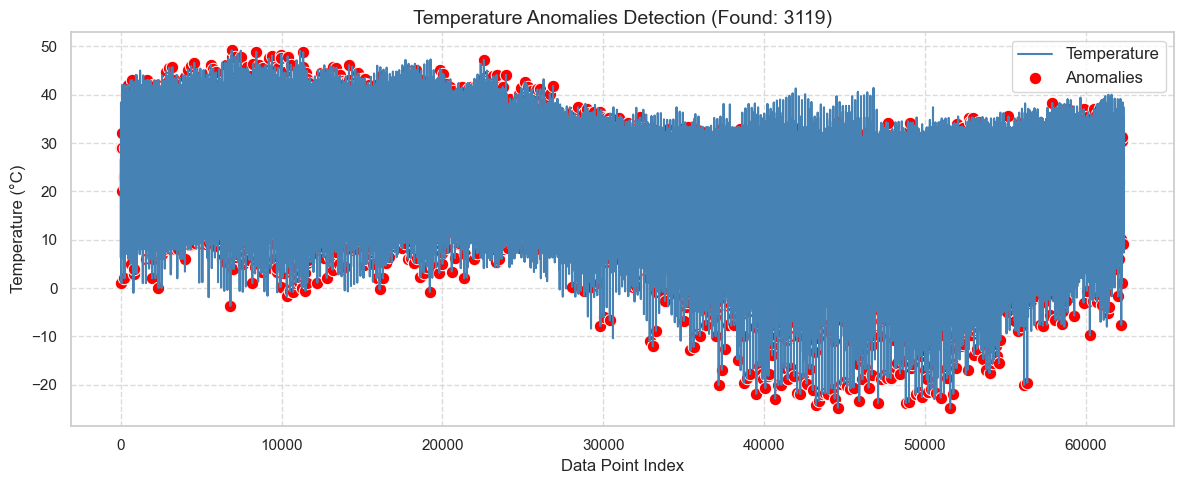

In [39]:
sns.set(style="whitegrid")
numeric_cols = df.select_dtypes(include=[np.number]).columns
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(df[numeric_cols])
anomalies = df[df['anomaly'] == -1]


plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['temperature_celsius'], color='steelblue', label='Temperature')
sns.scatterplot(x=anomalies.index, y=anomalies['temperature_celsius'], 
                color='red', s=80, label='Anomalies')
plt.title(f"Temperature Anomalies Detection (Found: {len(anomalies)})", fontsize=14)
plt.xlabel("Data Point Index", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

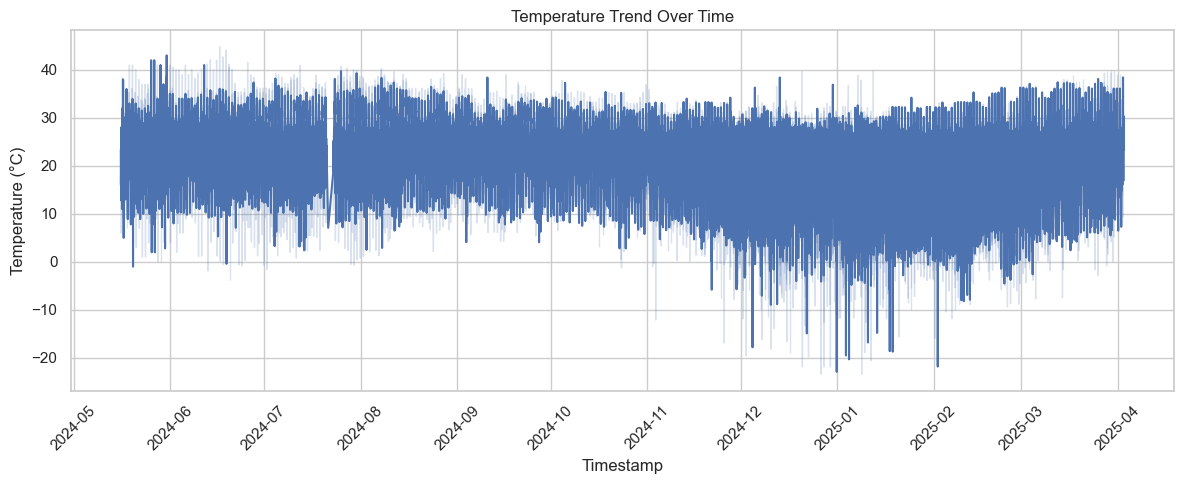

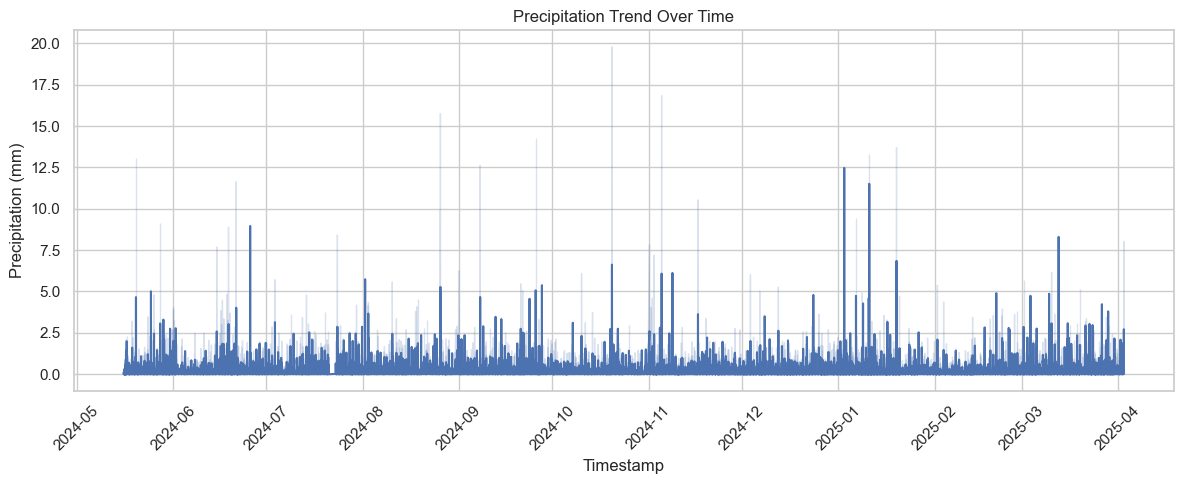

In [ ]:
df_sorted = df.sort_values(by='last_updated')

# Plot temperature trend over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_sorted, x='last_updated', y='temperature_celsius')
plt.title("Temperature Trend Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot precipitation trend over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_sorted, x='last_updated', y='precip_mm')
plt.title("Precipitation Trend Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Precipitation (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Model Building

21:54:51 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing


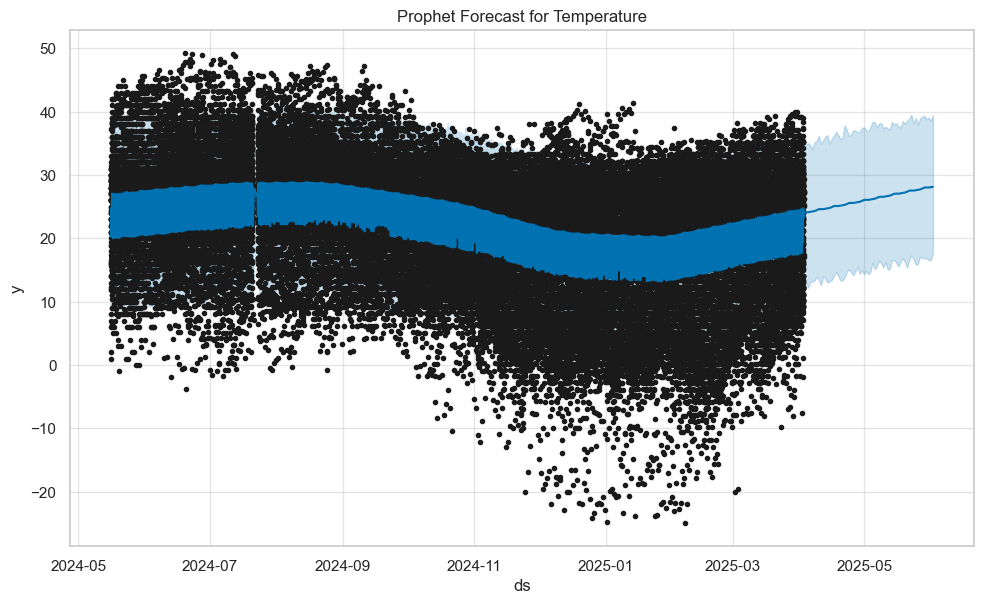

In [ ]:
from prophet import Prophet

prophet_df = df.reset_index()[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=60)  # Forecast for 2 month
forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title("Prophet Forecast for Temperature")
plt.show()

In [ ]:
# Evaluate
merged = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds', how='inner')
prophet_eval = {
    'MAE': mean_absolute_error(merged['y'], merged['yhat']),
    'RMSE': np.sqrt(mean_squared_error(merged['y'], merged['yhat'])),
    'R2': r2_score(merged['y'], merged['yhat'])
}

merged_result = merged.rename(columns={'y': 'Actual', 'yhat': 'Prophet Forecast'})
prophet_eval

{'MAE': 0.09335424385266451,
 'RMSE': 0.11654862138516028,
 'R2': 0.19107436100218023}

##### Forecasting with Multiple Models

In [58]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.sort_values('last_updated', inplace=True)
features = ['temperature_celsius', 'humidity', 'wind_kph', 'air_quality_PM2.5', 'air_quality_PM10']
df = df[features].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])
    return np.array(X), np.array(y)

SEQ_LEN = 5
X, y = create_sequences(scaled_data, SEQ_LEN)

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LEN, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, validation_split=0.1)

# Predict
y_pred = model.predict(X_test)


# Evaluation
temp_index = 0
min_temp = scaler.data_min_[temp_index]
max_temp = scaler.data_max_[temp_index]
y_test_real = y_test * (max_temp - min_temp) + min_temp
y_pred_real = y_pred[:, 0] * (max_temp - min_temp) + min_temp

lstm_eval = {
    'MAE': mean_absolute_error(y_test_real, y_pred_real),
    'RMSE': np.sqrt(mean_squared_error(y_test_real, y_pred_real)),
    'R2': r2_score(y_test_real, y_pred_real)
}

lstm_result_df = pd.DataFrame({
    'Actual Temperature': y_test_real,
    'LSTM Forecast': y_pred_real
})

lstm_eval

/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


{'MAE': 8.41210505073846, 'RMSE': 10.245266107535969, 'R2': 0.0241425637477497}

In [91]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
features = ['temperature_celsius', 'humidity', 'wind_kph', 'air_quality_PM2.5', 'air_quality_PM10', 'pressure_mb', 'pressure_in', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide']
df_grouped = df.groupby('last_updated')[features].mean().sort_index()
for col in features:
    df_grouped[f'{col}_lag1'] = df_grouped[col].shift(1)
df_grouped.dropna(inplace=True)

X = df_grouped[[f'{col}_lag1' for col in features]]
y = df_grouped['temperature_celsius']

split_index = int(len(df_grouped) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)

xgb_eval = {
    'MAE': mean_absolute_error(y_test, xgb_preds),
    'RMSE': np.sqrt(mean_squared_error(y_test, xgb_preds)),
    'R2': r2_score(y_test, xgb_preds)
}

xgb_result = df_grouped.iloc[split_index:].copy()
xgb_result['XGBoost Forecast'] = xgb_preds

xgb_eval

{'MAE': 5.659093791715642,
 'RMSE': 7.571294447982145,
 'R2': 0.05646291653450042}

##### Ensemble

In [ ]:
# Prepare Stacking Ensemble using ARIMA + XGBoost + Simulated Prophet-style forecast
# Re-import necessary packages and reload the dataset
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

# Load and preprocess dataset
df = pd.read_csv('Global Weather Repository.csv')
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Group and sort by timestamp for time series consistency
features = ['temperature_celsius', 'humidity', 'wind_kph', 'air_quality_PM2.5', 'air_quality_PM10']
df_grouped = df.groupby('last_updated')[features].mean().sort_index()
df_grouped['temp_lag1'] = df_grouped['temperature_celsius'].shift(1)
df_grouped['humidity_lag1'] = df_grouped['humidity'].shift(1)
df_grouped['wind_kph_lag1'] = df_grouped['wind_kph'].shift(1)
df_grouped['pm25_lag1'] = df_grouped['air_quality_PM2.5'].shift(1)
df_grouped['pm10_lag1'] = df_grouped['air_quality_PM10'].shift(1)
df_grouped.dropna(inplace=True)

# Create train/test split
split_index = int(len(df_grouped) * 0.8)
train_df = df_grouped.iloc[:split_index]
test_df = df_grouped.iloc[split_index:]

# === ARIMA ===
arima_model = ARIMA(train_df['temperature_celsius'], order=(1, 0, 0)).fit()
arima_preds = arima_model.forecast(steps=len(test_df))

# === XGBoost ===
xgb_features = ['temp_lag1', 'humidity_lag1', 'wind_kph_lag1', 'pm25_lag1', 'pm10_lag1']
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(train_df[xgb_features], train_df['temperature_celsius'])
xgb_preds = xgb_model.predict(test_df[xgb_features])

# === Simulated Prophet (use rolling average to simulate trend-like predictions) ===
prophet_like_preds = train_df['temperature_celsius'].rolling(window=10, min_periods=1).mean().iloc[-1]
prophet_like_preds = np.full_like(arima_preds, fill_value=prophet_like_preds)

# === Stacking ===
X_meta = np.vstack([arima_preds, prophet_like_preds, xgb_preds]).T
y_true = test_df['temperature_celsius'].values

stack_model = LinearRegression()
stack_model.fit(X_meta, y_true)
stack_preds = stack_model.predict(X_meta)

# === Evaluation ===
def evaluate(true, pred):
    return {
        'MAE': mean_absolute_error(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'R2': r2_score(true, pred)
    }

results = {
    'ARIMA': evaluate(y_true, arima_preds),
    'Simulated Prophet': evaluate(y_true, prophet_like_preds),
    'XGBoost': evaluate(y_true, xgb_preds),
    'Stacked Ensemble': evaluate(y_true, stack_preds)
}

results_df = pd.DataFrame(results).T
results_df

/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported inde

,MAE,RMSE,R2
ARIMA,6.069441,8.100469,-0.080038
Simulated Prophet,7.304163,8.785497,-0.270432
XGBoost,6.057132,8.028095,-0.060825
Stacked Ensemble,5.828159,7.646851,0.037537


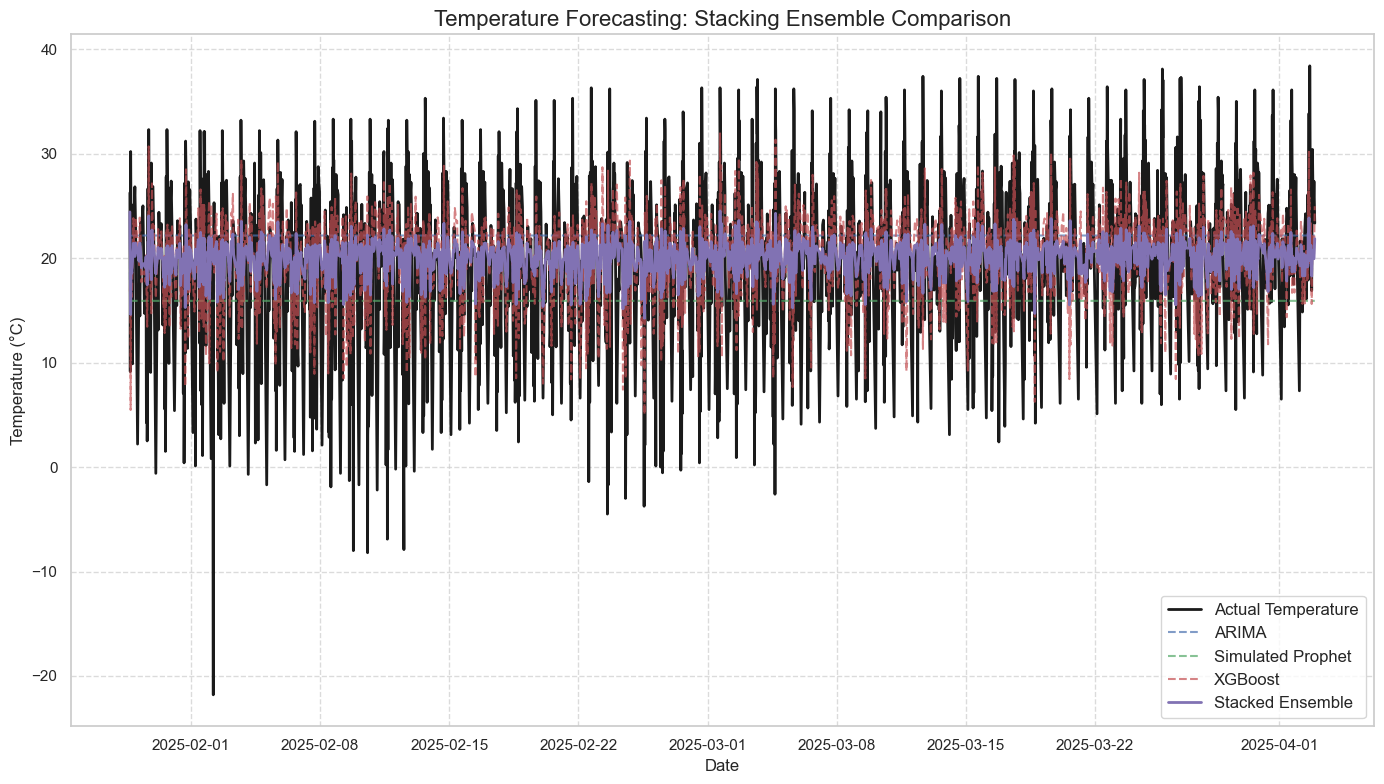

In [67]:
plt.figure(figsize=(14, 8))
plt.plot(test_df.index, y_true, 'k-', label='Actual Temperature', linewidth=2)
plt.plot(test_df.index, arima_preds, 'b--', label='ARIMA', alpha=0.7)
plt.plot(test_df.index, prophet_like_preds, 'g--', label='Simulated Prophet', alpha=0.7)
plt.plot(test_df.index, xgb_preds, 'r--', label='XGBoost', alpha=0.7)
plt.plot(test_df.index, stack_preds, 'm-', label='Stacked Ensemble', linewidth=2)

plt.title('Temperature Forecasting: Stacking Ensemble Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### Unique Analyses

In [72]:
# 1. Climate Analysis: Summary by country
climate_summary = df.groupby('country')['temperature_celsius'].agg(['mean', 'std', 'min', 'max']).reset_index()
climate_summary.columns = ['country', 'avg_temp', 'std_temp', 'min_temp', 'max_temp']
climate_summary

,country,avg_temp,std_temp,min_temp,max_temp
0,Afghanistan,18.007477,10.760855,-3.3,36.1
1,Albania,21.883178,9.223880,6.2,39.2
2,Algeria,22.541563,6.731980,9.3,38.2
3,Andorra,10.761994,8.860008,-8.0,28.9
4,Angola,27.197508,2.310369,22.2,32.2
...,...,...,...,...,...
205,Гватемала,15.900000,NaN,15.9,15.9
206,Польша,24.200000,NaN,24.2,24.2
207,Турция,34.000000,NaN,34.0,34.0
208,كولومبيا,23.100000,NaN,23.1,23.1


In [73]:
# 2. Environmental Impact: Correlation
air_quality_vars = ['air_quality_PM2.5', 'air_quality_PM10'] #examples
weather_vars = ['temperature_celsius', 'humidity', 'wind_kph']
corr_df = df[weather_vars + air_quality_vars].corr()
corr_df

,temperature_celsius,humidity,wind_kph,air_quality_PM2.5,air_quality_PM10
temperature_celsius,1.000000,-0.340281,0.065385,-0.053912,0.043708
humidity,-0.340281,1.000000,-0.065617,-0.144782,-0.199907
wind_kph,0.065385,-0.065617,1.000000,-0.043760,0.037696
air_quality_PM2.5,-0.053912,-0.144782,-0.043760,1.000000,0.628881
air_quality_PM10,0.043708,-0.199907,0.037696,0.628881,1.000000


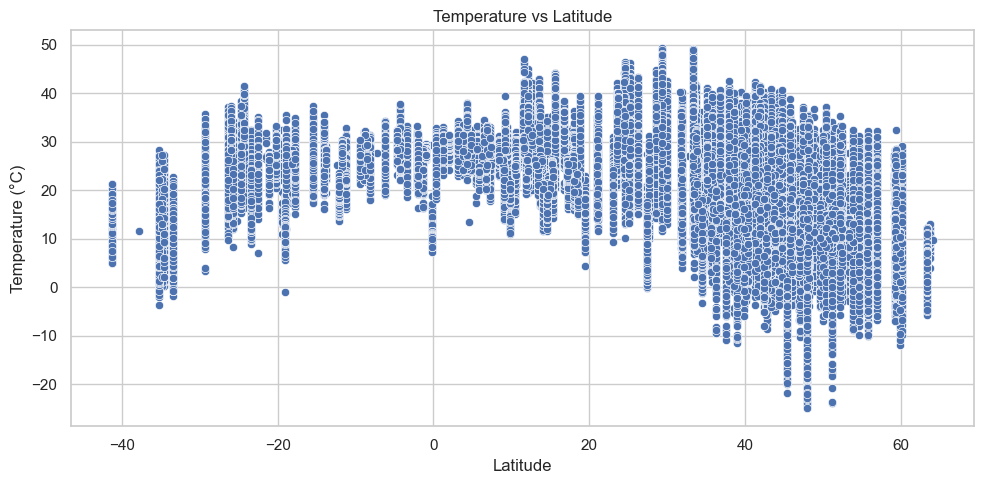

In [74]:
# 3. Spatial Analysis: Temperature vs Latitude
plt.figure(figsize=(10, 5))
sns.scatterplot(x='latitude', y='temperature_celsius', data=df)
plt.title("Temperature vs Latitude")
plt.xlabel("Latitude")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()

##### Feature Importance

/var/folders/8z/kr38t9vx4693jfmjj5wf0b000000gn/T/ipykernel_47239/2531790338.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')


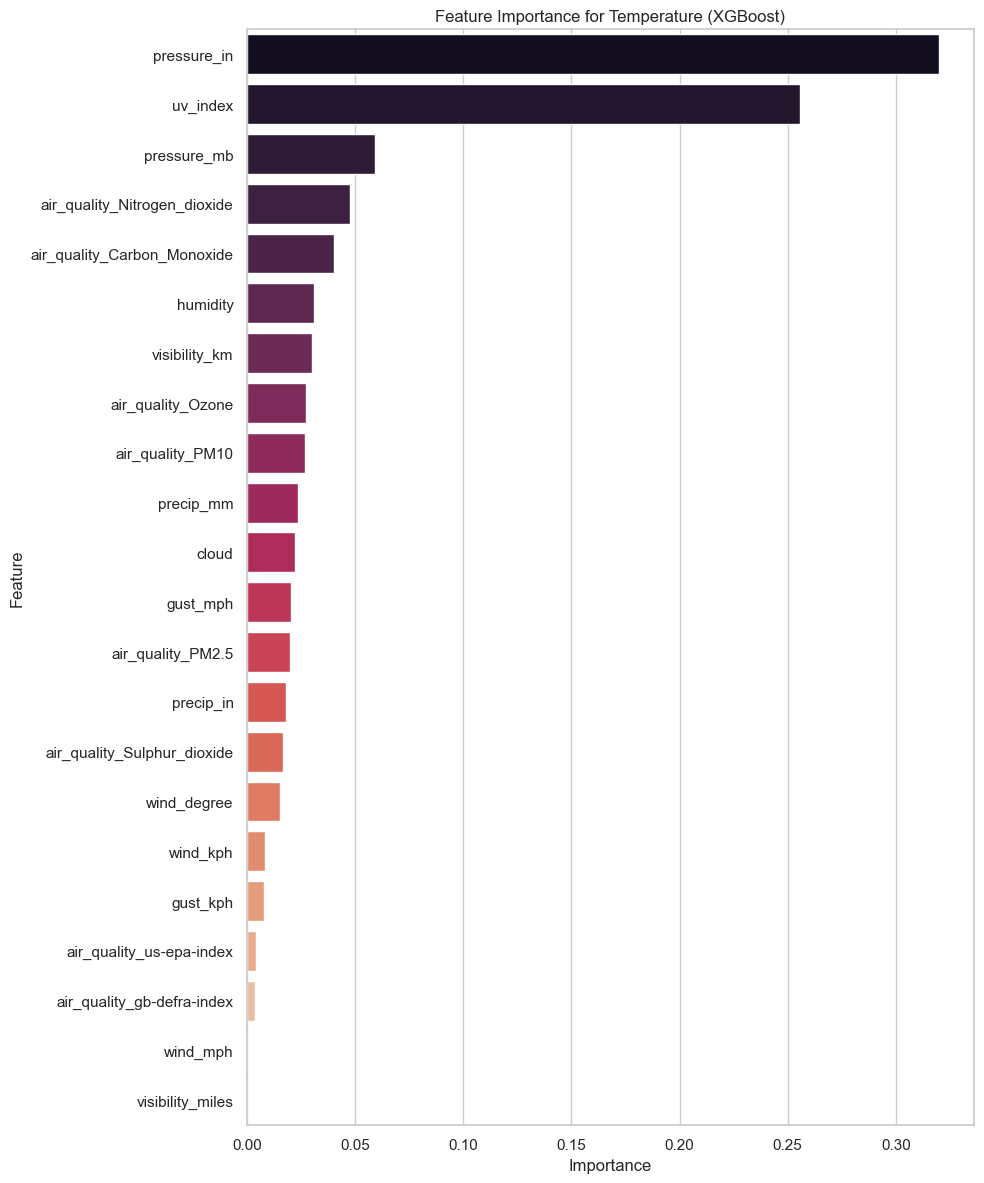

In [ ]:
features = [
    'humidity', 'cloud', 'uv_index',
    'air_quality_gb-defra-index', 'air_quality_PM2.5', 'air_quality_Nitrogen_dioxide',
    'air_quality_PM10', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Sulphur_dioxide', 'air_quality_us-epa-index',
    'wind_kph', 'wind_mph', 'wind_degree', 'gust_kph', 'gust_mph',
    'pressure_mb', 'pressure_in',
    'visibility_km', 'visibility_miles',
    'precip_mm', 'precip_in',
]

df = df.dropna(subset=features + ['temperature_celsius'])

X = df[features]
y = df['temperature_celsius']

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
plt.title("Feature Importance for Temperature (XGBoost)")
plt.tight_layout()
plt.show()